# Finding What Makes an All-Star with Machine Learning  

## Introduction 

NBA players can be grouped into different categories; prospect, role player, and star. Stars stand out among peers with their on-court impact, and are few in number. For the purpose of creating a more objective analysis, the definition of a star will be equated to an all-star. This analysis will use a data science and machine learning approach to find out what makes an all-star. Results of the analysis can be used in a variety of applications. For players, following the results can provide insight as to how to become an all-star. For fans, results can explain why certain all-stars were selected in the past, and predict who will become an all-star in the future.   

## Resources  

Python packages are imported for deep learning and machine learning, particularily scikit-learn and tensorflow with the Keras API. Pandas and numpy are used for cleaning and various other tasks, while seaborn and matplotlib are used to generate visualizations.

In [1]:
# !pip install matplotlib seaborn scikit-learn tensorflow gradio shap sqlalchemy joblib adjust-text 

In [2]:
import pandas as pd, numpy as np, sklearn as sklm
import matplotlib.pyplot as plt, seaborn as sns 
import tensorflow as tf, gradio 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 25)

import sqlalchemy, sqlite3   
from sklearn.linear_model import LogisticRegression, LinearRegression 
from sklearn.metrics import accuracy_score 
import shap, joblib

import sys, os    
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('functions.py'), '..', '..', 'PY')))
import functions 

from adjustText import adjust_text 

import warnings 
warnings.filterwarnings('ignore')

In [35]:
tf.keras.__version__

'3.4.1'

In [3]:
def combine_dfs(dfs):
    master = dfs[0]
    for i in range(1, len(dfs)):
        cols_new = dfs[i].columns.difference(master.columns).tolist() 
        cols_new.append('Player') 
        master = pd.merge(master, dfs[i][cols_new], on="Player") 
    return master 

def clean_player(name): 
    i = name.find('*') 
    clean_name = name 
    if i > -1: 
        clean_name = clean_name[:i] 
    return clean_name 

## Dataset 
A dataset with 19374 rows and 70 columns is loaded into the workspace. This includes player data starting from the 1979-80 season, the season that the 3 point line was introduced. Each row represents a player's stats for a given season, and each column represents a single stat. 
Statistics include per-game averages such as points per game, totals such as the number of games played, and advanced stats such as usage percentage. 
Each row includes an indication of whether or not the player was an all-star during the given season. 
The data will be used to train and evaluate the all-star prediction models. 

In [4]:
db_path = "sqlite:///../../DB/ballbase.db" 

engine = sqlalchemy.create_engine(db_path) 
seasons = functions.generate_seasons(1979, 2024) 
master = pd.DataFrame() 
ssn = pd.DataFrame() 

for season in seasons: 
    master_temp = pd.read_sql("master_" + season, con=engine).drop('GS', axis=1) 
    master_temp.insert(1, "Season", [season]*len(master_temp), True) 
    master_temp['Season'] = season.replace('_', '-') 

    master = pd.concat([master, master_temp], axis=0) 

allstars = pd.read_sql('allstars', con=engine) 

master = master if 'AS' in master.columns else master.merge(allstars, how='left', on=['Player', 'Season']) 
master = master.rename(columns = {'Status':'AS'}) 
master['AS'] = master['AS'].apply(lambda x: False if pd.isna(x) else True)
master['AS'] = master['AS'].astype("float64")

for col_name in master.columns: 
    # master[col_name].fillna(np.mean(master[col_name].dropna(axis=0)), inplace=True)
    master[col_name].fillna(0, inplace=True)

numeric_df = master[master['Season']!='2023-24'] 
numeric_df = numeric_df.select_dtypes(include = [np.number])  

master 


,Player,Season,Pos,Age,Tm,GP,MPG,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORPG,DRPG,RPG,APG,SPG,BPG,ToPG,PF,PPG,T2P,T2PA,T3P,T3PA,TAST,TBLK,TDRB,TFG,TFGA,TFT,TFTA,TMP,TORB,TPF,TPTS,TSTL,TTOV,TTRB,DRtg,ORtg,3PAr,AST%,BLK%,BPM,DBPM,DRB%,DWS,FTr,OBPM,ORB%,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS
0,Abdul Jeelani,1979-80,SF,25.0,POR,77.0,16.7,3.7,7.3,51.0,0.0,0.1,0.0,3.7,7.3,51.5,51.0,2.1,2.6,78.9,1.5,2.0,3.5,1.2,0.5,0.5,1.5,2.0,9.6,288.0,559.0,0.0,6.0,95.0,40.0,156.0,288.0,565.0,161.0,204.0,1286.0,114.0,155.0,737.0,40.0,117.0,270.0,104.0,109.0,0.011,11.6,1.8,1.5,-0.1,13.5,1.5,0.361,1.7,9.6,2.3,18.7,1.5,15.2,11.5,56.3,24.6,1.1,3.8,0.141,0.0
1,Adrian Dantley,1979-80,SF,24.0,UTA,68.0,39.3,10.7,18.6,57.6,0.0,0.0,0.0,10.7,18.6,57.7,57.6,6.5,7.7,84.2,2.7,4.9,7.6,2.8,1.4,0.2,3.4,3.1,28.0,730.0,1265.0,0.0,2.0,191.0,14.0,333.0,730.0,1267.0,443.0,526.0,2674.0,183.0,211.0,1903.0,96.0,233.0,516.0,110.0,119.0,0.002,12.3,0.3,3.7,-1.6,14.0,1.1,0.415,5.3,8.3,9.5,24.3,1.8,13.5,11.3,63.5,27.8,3.8,10.5,0.189,1.0
2,Al Skinner,1979-80,SG,27.0,PHI,2.0,5.0,0.5,1.0,50.0,0.0,0.0,0.0,0.5,1.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,1.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,10.0,0.0,1.0,2.0,0.0,2.0,0.0,111.0,65.0,0.000,25.4,0.0,-4.8,-0.2,0.0,0.0,0.000,-4.6,0.0,0.0,-0.6,0.0,50.0,0.0,50.0,16.0,0.0,0.0,-0.152,0.0
3,Alex English,1979-80,SF,26.0,IND-DEN,78.0,30.8,7.1,14.3,49.7,0.0,0.1,33.3,7.1,14.2,49.8,49.8,2.7,3.4,78.9,3.4,4.3,7.8,2.9,0.9,0.8,2.7,2.6,16.9,551.0,1107.0,2.0,6.0,224.0,62.0,336.0,553.0,1113.0,210.0,266.0,2401.0,269.0,206.0,1318.0,73.0,214.0,605.0,107.0,106.0,0.005,13.9,1.4,0.4,-1.2,14.9,2.0,0.239,1.6,11.3,3.3,18.0,1.4,14.8,13.1,53.6,23.4,1.5,5.3,0.105,0.0
4,Allan Bristow,1979-80,SF,28.0,UTA,82.0,28.1,4.6,9.6,48.0,0.0,0.1,28.6,4.6,9.5,48.2,48.2,2.4,3.0,81.1,2.1,4.2,6.2,4.2,1.1,0.1,2.2,2.6,11.6,375.0,778.0,2.0,7.0,341.0,6.0,342.0,377.0,785.0,197.0,243.0,2304.0,170.0,211.0,953.0,88.0,179.0,512.0,110.0,108.0,0.009,21.4,0.1,0.6,-0.8,16.7,1.2,0.310,1.4,9.0,3.2,16.6,1.9,16.7,13.0,53.4,20.0,1.5,4.4,0.091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,Zach LaVine,2023-24,SG,28.0,CHI,25.0,34.9,6.8,15.0,45.2,2.4,6.8,34.9,4.4,8.3,53.6,53.1,3.5,4.1,85.4,0.3,4.8,5.2,3.9,0.8,0.3,2.1,2.3,19.5,111.0,207.0,59.0,169.0,98.0,8.0,121.0,170.0,376.0,88.0,103.0,872.0,8.0,57.0,487.0,21.0,52.0,129.0,118.0,113.0,0.449,16.8,0.9,0.1,-0.7,15.8,0.6,0.274,0.8,1.0,0.8,15.1,1.2,11.0,8.3,57.8,23.8,0.5,1.5,0.080,0.0
19371,Zavier Simpson,2023-24,PG,26.0,MEM,7.0,23.0,2.4,7.7,31.5,0.7,2.4,29.4,1.7,5.3,32.4,36.1,0.4,0.6,75.0,0.6,2.3,2.9,3.6,1.0,0.4,1.4,1.6,6.0,12.0,37.0,5.0,17.0,25.0,3.0,16.0,17.0,54.0,3.0,4.0,161.0,4.0,11.0,42.0,7.0,10.0,20.0,115.0,86.0,0.315,22.5,1.7,-5.9,0.3,11.3,0.2,0.074,-6.2,2.6,-0.3,6.3,2.1,15.2,6.8,37.7,17.5,-0.2,-0.2,-0.046,0.0
19372,Zeke Nnaji,2023-24,PF,23.0,DEN,58.0,9.9,1.2,2.6,46.3,0.1,0.4,26.1,1.1,2.2,50.0,48.3,0.7,1.1,67.7,1.1,1.1,2.2,0.6,0.3,0.7,0.5,1.4,3.2,63.0,126.0,6.0,23.0,32.0,38.0,65.0,69.0,149.0,42.0,62.0,576.0,61.0,81.0,186.0,15.0,27.0,126.0,112.0,113.0,0.154,7.0,5.6,-3.7,0.1,12.2,0.8,0.416,-3.8,12.1,0.4,12.4,1.3,13.3,12.1,52.8,15.4,-0.2,1.2,0.099,0.0
19373,Ziaire Williams,2023-24,SF,22.0,MEM,51.0,20.4,2.9,7.4,39.7,1.1,3.7,30.7,1.8,3.7,48.7,47.4,1.2,1.5,82.7,0.7,2.8,3.5,1.5,0.7,0.2,1.3,1.7,8.2,92.0,189.0,58.0,189.0,75.0,9.0,145.0,150.0,378.0,62.0,75.0,1038.0,35.0,85.0,420.0,36.0,66.0,180.0,115.0,98.0,0.500,11.1,0.8,-4.5,-0.4,15.9,1.1,0.198,-4.0,3.5,-0.9,9.3,1.7,13.8,9.5,51.1,19.7,-0.6,0.2,0.010,0.0


In [5]:
master.to_sql('master_as', con=engine, if_exists='replace', index=False ) 
numeric_df.to_sql('numeric_as', con=engine, if_exists='replace', index=False) 

18803

In [6]:
numeric_df.shape

(18803, 66)

## Models

The machine-learning models learn patterns from the data to make all-star predictions. They all take different strategies to learn from the data, but ultimately all aim to make the most accurate all-star prediction. 

### Logistic Regression Model 

A logistic regression model predicts a variable with only 2 possible values. It follows a simple decision rule based on a probability to decide the classification (in this case, All-Star or non All-Star). This is the simplest type of model and All-Star predictions are likely to be less nuanced than the other models.  

In [7]:
X_train, X_test, y_train, y_test = sklm.model_selection.train_test_split(numeric_df.drop('AS', axis=1), numeric_df['AS'], test_size=0.2, random_state=1) 
lr_model = LogisticRegression(fit_intercept=True, solver='lbfgs') 
lr_model.fit(X_train, y_train)

LogisticRegression()

In [8]:
joblib.dump(lr_model, "lr_model.pkl") 

['lr_model.pkl']

In [9]:
lr_shap_path = 'lr_shap_values.npy' 

if os.path.exists(lr_shap_path): 
    lr_shap_values = np.load(lr_shap_path)  
else: 
    background = shap.kmeans(X_train, 10)
    explainer = shap.KernelExplainer(lr_model.predict, background)
    lr_shap_values = explainer.shap_values(X_test.sample(1000)) 
    np.save(lr_shap_path, lr_shap_values) 

I can evaluate the model features using SHAP values. The true definition is a little complex, but it essentially allows us to evaluate the significance of each feature in the final predictions. 


In [10]:
train_accuracy = sklm.metrics.accuracy_score(y_train, lr_model.predict(X_train))
print(f"Train Accuracy: {train_accuracy}") 

test_accuracy = sklm.metrics.accuracy_score(y_test, lr_model.predict(X_test))
print(f"Test Accuracy {test_accuracy}") 

Train Accuracy: 0.9680228692992953
Test Accuracy 0.9688912523265089


Text(0.5, 1.0, 'Logistic Regression Important Stats')

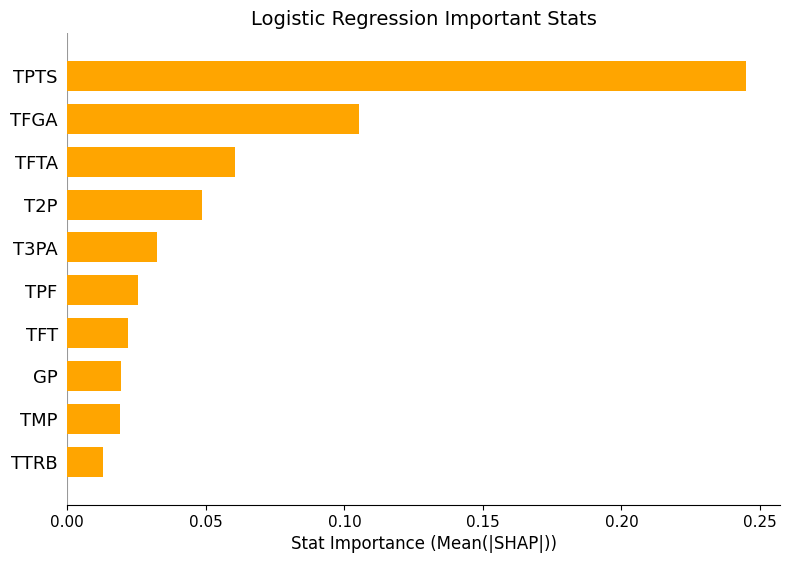

In [11]:
plt.figure(figsize=(8, 4)) 
shap.summary_plot(lr_shap_values, X_test, plot_type="bar", max_display=10, color="orange", axis_color="black", show=False) 

plt.xlabel('Stat Importance (Mean(|SHAP|))', size=12) 
plt.title('Logistic Regression Important Stats', size=14)

Accuracy on training and testing data was pretty good, hovering around 97%. The model's priorization of scoring was effective at predicting All-Stars. 
This approach favours high volume scorers who take a lot of shots and get to the line consistently. Interestingly, the model favours shot attempts over shots made, and free-throw attempts over free-throws made. This is likely influenced by dominant dominant All-Star big men such as Shaquille O'Neal and Kareem Abdul-Jabbar, who draw a lot of contact and score primarily inside the arc.  

### Neural Network Sequential Model 
The neural network learns from the data and determines the importance of each stat in predicting an all-star. It consists of a sequence of layers that take in data and update the importance of each stat. The stats are each assigned a level of importance to output a probability that a player is an all-star. 

In [12]:
numeric_tensor = tf.convert_to_tensor(numeric_df.drop('AS', axis=1) )  
normalizer = tf.keras.layers.Normalization(axis=-1) 
normalizer.adapt(numeric_tensor) 

In [13]:
seq_model = tf.keras.Sequential() 
seq_model.add(normalizer) 
seq_model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(64,))) 
seq_model.add(tf.keras.layers.Dense(units=10, activation='relu')) 
seq_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  

seq_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
# history = seq_model.fit(tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train), epochs=10, batch_size=1, validation_split=0.1) 

weights_path = 'seq_model.weights.h5'

if os.path.exists(weights_path):
    print("Loading saved weights...")
    seq_model.build(input_shape=(None, 65))
    seq_model.load_weights(weights_path)
else:
    print("Weights not found. Training the model...")
    seq_model.fit(X_train, y_train, epochs=10, batch_size=1) 
    seq_model.save_weights(weights_path)
    seq_model.save('seq_model.keras')

Loading saved weights...


In [14]:
test_loss, test_accuracy = seq_model.evaluate(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test))   
print(f'Test Accuracy: {test_accuracy}') 

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9762 - loss: 0.0642
Test Accuracy: 0.9736772179603577


In [15]:
nn_shap_path = 'nn_shap_values.npy'

if os.path.exists(nn_shap_path): 
    nn_shap_values = np.load(nn_shap_path)  
else: 
    background = shap.kmeans(X_train, 10)
    explainer = shap.KernelExplainer(seq_model.predict, background)
    nn_shap_values = explainer.shap_values(X_test.sample(1000))
    nn_shap_values = np.squeeze(nn_shap_values) 
    np.save(nn_shap_path, nn_shap_values) 

Text(0.5, 1.0, 'Neural Network Important Stats')

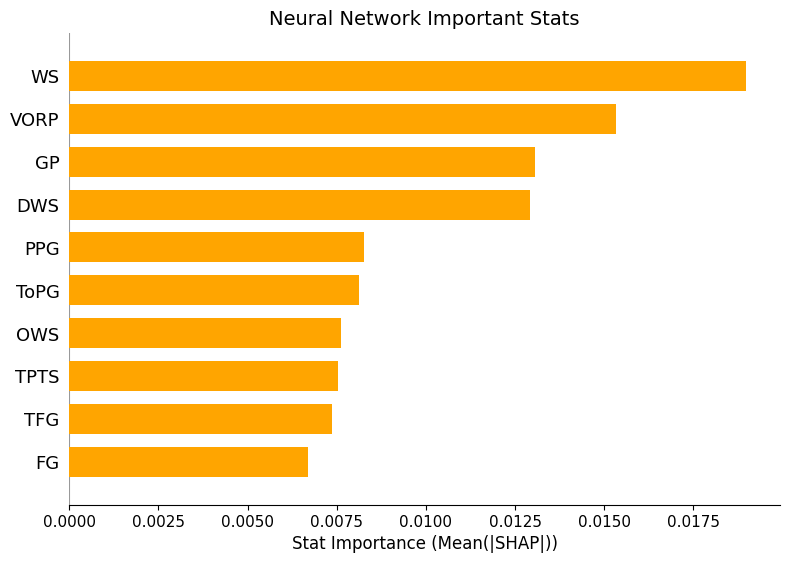

In [16]:
plt.figure(figsize=(8, 4)) 
shap.summary_plot(nn_shap_values, X_test, plot_type="bar", max_display=10, color="orange", axis_color="black", show=False) 

plt.xlabel('Stat Importance (Mean(|SHAP|))', size=12) 
plt.title('Neural Network Important Stats', size=14)

The neural network places great importance on Ws (Win Shares) and VORP (Value Over Replacement Player), when predicting an all-star. Win shares measure a player's impact on winning, and favour players on winning teams. VORP essentially compares a given player's performance to the performance of an average player. Games played are also important, which supports the theory that all-stars are usually players who have been available for their teams. An interesting stat that the model valued is turnovers per game (TOV). This may be because only players that earned the trust of their respective teams are able to have enough possession and decision making opporunities to cause a significant number of turnovers. 


### Random Forest Model 
The random forest model consists of a group of 200 decison trees. It makes predictions based off the outcome of the decision trees. 
Each decision tree makes decisions based on a sequence of criteria (Ex. points per game above or below 20 ppg), and makes the final decision based on the results. 

In [17]:
from sklearn.ensemble import RandomForestClassifier 
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, max_features='sqrt', min_samples_split=10, min_samples_leaf=5, bootstrap=True)
rf_model.fit(X_train, y_train) 

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200)

In [18]:
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [19]:
rf_train_pred = rf_model.predict(X_train) 
rf_test_pred = rf_model.predict(X_test) 

rf_train_acc = accuracy_score(y_train, rf_train_pred) 
rf_test_acc = accuracy_score(y_test, rf_test_pred) 
# rf_train_acc  
print(f"Test Accuracy: {rf_test_acc}")

Test Accuracy: 0.9710183461845254


In [20]:
rf_shap_path = 'rf_shap_values.npy'

if os.path.exists(rf_shap_path): 
    rf_shap_values = np.load(rf_shap_path)  
else: 
    background = shap.kmeans(X_train, 10)
    explainer = shap.KernelExplainer(rf_model.predict, background)
    rf_shap_values = explainer.shap_values(X_test.sample(1000))
    rf_shap_values = np.squeeze(rf_shap_values) 
    np.save(rf_shap_path, rf_shap_values) 

Text(0.5, 1.0, 'Random Forest Important Stats')

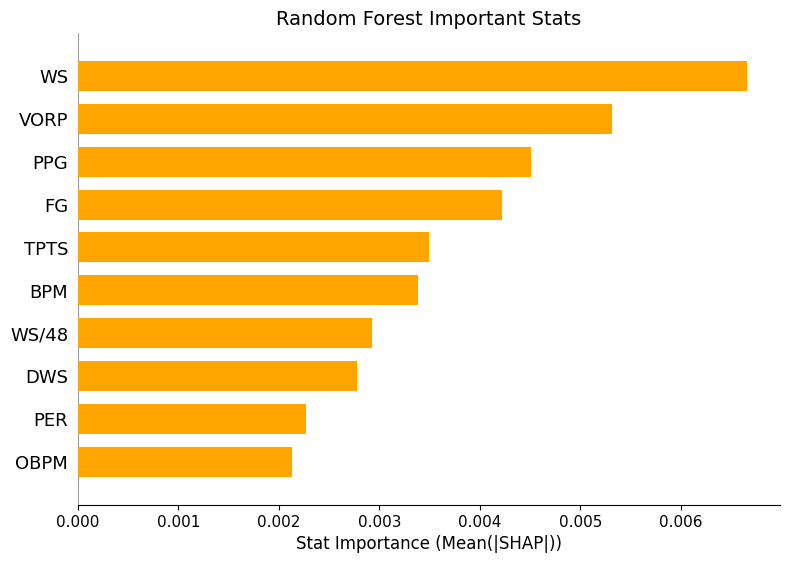

In [21]:
plt.figure(figsize=(8, 4)) 
shap.summary_plot(rf_shap_values, X_test, plot_type="bar", max_display=10, color="orange", axis_color="black", show=False) 

plt.xlabel('Stat Importance (Mean(|SHAP|))', size=12) 
plt.title('Random Forest Important Stats', size=14) 
 

Similar to the neural network, the random forest model values Value Over Replacement Player and Win Shares, although it values points far more. It is also the first model that values efficiency as an important statistic, in this case PER (Player Efficiency Rating). So it is valid to conclude that efficiency may have some value in predicting all-stars, although it is clearly not significant considering that it does not appear in any of the other models. An interesting point is that the model also highly values BPM (Box Plus Minus). BPM is essentially the same as VORP, aside from the fact that it does not account for playing time. This stat was notably absent from the neural network's most important features, and highlights the difference in the model's decision making process. 

In [22]:
# def predict_ensemble(row): 
#     example = master[(master['Player']==row['Player']) & (master['Season']==row['Season'])] 
#     example = pd.DataFrame(example)
#     example = example.drop(['AS', 'Player', 'Season'], axis=1) 
#     # example = example.select_dtypes(include=[np.number]).drop('AS', axis=1) 
#     row['AS'] = int(row['AS'])
#     row['LR'] = int(lr_model.predict(example)[0])  
#     row['NN'] = int(seq_model.predict(tf.convert_to_tensor(example))[0][0] > 0.5) 
#     row['RF'] = int(rf_model.predict(example)[0]) 

#     row['ENS'] = int((row['LR'] + row['NN'] + row['RF']) >= 2) 
#     return row 
# example = master[(master['Player']=='Bam Adebayo') & (master['Season']=='2023-24')]
# example = pd.DataFrame(example)
# example = example.drop(['AS', 'Player', 'Season'], axis=1) 
# example = example.to_numpy() 
# example 

def apply_predictions(row): 
    example = master[(master['Player']==row['Player']) & (master['Season']==row['Season'])] 
    example = pd.DataFrame(example)
    example = example.drop(['AS', 'Player', 'Season', 'Pos', 'Tm'], axis=1) 
    # example = example.select_dtypes(include=[np.number]).drop('AS', axis=1) 
    row['AS'] = int(row['AS'])
    row['LR'] = int(lr_model.predict(example)[0])  
    row['NN'] = int(seq_model.predict(tf.convert_to_tensor(example))[0][0] > 0.5) 
    row['RF'] = int(rf_model.predict(example)[0]) 

    # row['ENS'] = int((row['LR'] + row['NN'] + row['RF']) >= 2) 
    return row 
    

### Testing on the 2023-24 Season 
The 2023-24 season was purposefully not used to train the models, so it serves as a good set to test them. Since the models haven't seen who was an all-star during this season, they can only make guesses based off of the knowledge they learned from prior seasons. 

In [23]:
s_24 = master[master['Season']=='2023-24'] 
s_24 = s_24.apply(lambda x: apply_predictions(x), axis=1)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [24]:
# acc_ens = len(s_24[s_24['ENS']==s_24['AS']])/len(s_24) 
acc_lr = len(s_24[s_24['LR']==s_24['AS']])/len(s_24) 
acc_nn = len(s_24[s_24['NN']==s_24['AS']])/len(s_24) 
acc_rf = len(s_24[s_24['RF']==s_24['AS']])/len(s_24) 
# dif_ens = 0
# dif_lr = len(s_24[s_24['LR']!=s_24['ENS']]) 
# dif_nn = len(s_24[s_24['NN']!=s_24['ENS']])
# dif_rf = len(s_24[s_24['RF']!=s_24['ENS']])
labels = ['Accuracy'] 

acc_df = pd.DataFrame({'Metric': labels,  'Neural Network':[acc_nn], 'Logistic Regression':[acc_lr], 'Random Forest':[acc_rf]}) 
acc_df.style.hide(axis="index")


Metric,Neural Network,Logistic Regression,Random Forest
Accuracy,0.975524,0.973776,0.972028


Of the 3 models, the neural network is the most accurate (albeit by a very small margin). The logistic regression model is surprisingly accurate, given that it is by far the simplest model. It shows that ignoring advanced stats and looking at stat totals (particularily total points) is sufficient to make accurate all-star predictions. The random forest is the most disappointing, likely due to being over complex and trying to incorporate too many stats. Even though it favours similar stats as the neural network, it appears to favour them less. It is important to note that any conclusion that arises from the random forest cannot be completely accurate due to the inherent element of randomness. 


## Visualization and Analysis 

### Model Errors 
Now that we understand the models and their accuracy, we can try to understand why they made some incorrect predictions. Below is a list of some players that were falsely predicted as all-stars by the models. 

In [25]:
false_pred = s_24[(s_24['AS']==0) & ((s_24['LR']==1) | (s_24['NN']==1) | (s_24['RF']==1))]  
false_pred  

,Player,Season,Pos,Age,Tm,GP,MPG,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORPG,DRPG,RPG,APG,SPG,BPG,ToPG,PF,PPG,T2P,T2PA,T3P,T3PA,TAST,TBLK,TDRB,TFG,TFGA,TFT,TFTA,TMP,TORB,TPF,TPTS,TSTL,TTOV,TTRB,DRtg,ORtg,3PAr,AST%,BLK%,BPM,DBPM,DRB%,DWS,FTr,OBPM,ORB%,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS,LR,NN,RF
18881,Chet Holmgren,2023-24,C,21.0,OKC,82.0,29.4,6.2,11.6,53.0,1.6,4.3,37.0,4.6,7.4,62.3,59.8,2.7,3.4,79.3,1.6,6.3,7.9,2.4,0.6,2.3,1.6,2.4,16.5,376.0,604.0,129.0,349.0,200.0,190.0,519.0,505.0,953.0,218.0,275.0,2413.0,129.0,197.0,1357.0,53.0,131.0,648.0,108.0,122.0,0.366,11.6,7.3,3.4,1.5,23.1,4.4,0.289,1.8,6.2,4.6,20.4,1.1,10.9,15.0,63.2,21.6,3.3,8.9,0.178,0,1,0,0
18927,De'Aaron Fox,2023-24,PG,26.0,SAC,74.0,35.9,9.7,20.9,46.5,2.9,7.8,36.9,6.8,13.1,52.2,53.4,4.2,5.7,73.8,0.9,3.7,4.6,5.6,2.0,0.4,2.6,2.6,26.6,506.0,969.0,214.0,580.0,418.0,31.0,273.0,720.0,1549.0,312.0,423.0,2659.0,67.0,193.0,1966.0,150.0,194.0,340.0,114.0,113.0,0.374,25.2,1.1,2.7,0.1,11.8,3.2,0.273,2.6,2.8,3.3,20.1,2.7,10.1,7.2,56.7,31.0,3.2,6.5,0.117,0,1,0,1
18932,DeMar DeRozan,2023-24,SF,34.0,CHI,79.0,37.8,8.2,17.2,48.0,0.9,2.8,33.3,7.3,14.3,50.9,50.7,6.6,7.7,85.3,0.5,3.8,4.3,5.3,1.1,0.6,1.7,2.0,24.0,575.0,1130.0,75.0,225.0,421.0,45.0,297.0,650.0,1355.0,522.0,612.0,2989.0,43.0,161.0,1897.0,90.0,135.0,340.0,118.0,122.0,0.166,21.8,1.5,1.8,-0.3,11.3,2.2,0.452,2.1,1.6,7.0,19.7,1.5,7.7,6.4,58.4,25.8,2.8,9.2,0.147,0,1,0,1
18935,Dejounte Murray,2023-24,SG,27.0,ATL,78.0,35.7,8.6,18.8,45.9,2.6,7.1,36.3,6.0,11.7,51.8,52.8,2.7,3.4,79.4,0.8,4.5,5.3,6.4,1.4,0.3,2.6,1.8,22.5,471.0,909.0,201.0,554.0,502.0,24.0,354.0,672.0,1463.0,208.0,262.0,2783.0,62.0,138.0,1753.0,111.0,201.0,416.0,119.0,114.0,0.379,27.9,0.8,1.7,-0.6,14.4,1.6,0.179,2.3,2.3,3.3,17.7,1.9,11.3,8.1,55.5,26.6,2.6,4.9,0.084,0,1,0,0
18952,Domantas Sabonis,2023-24,C,27.0,SAC,82.0,35.7,7.7,13.0,59.4,0.4,1.1,37.9,7.3,12.0,61.3,60.9,3.6,5.1,70.4,3.6,10.1,13.7,8.2,0.9,0.6,3.3,3.0,19.4,601.0,981.0,33.0,87.0,673.0,48.0,826.0,634.0,1068.0,292.0,415.0,2928.0,294.0,250.0,1593.0,74.0,272.0,1120.0,112.0,127.0,0.081,33.9,1.5,6.5,2.4,32.3,4.0,0.389,4.0,11.0,8.6,23.2,1.2,17.9,21.4,63.7,22.2,6.2,12.6,0.206,0,1,1,1
19061,Jarrett Allen,2023-24,C,25.0,CLE,77.0,31.7,6.7,10.6,63.4,0.0,0.1,0.0,6.7,10.6,63.8,63.4,3.0,4.1,74.2,3.2,7.4,10.5,2.7,0.7,1.1,1.6,1.9,16.5,519.0,813.0,0.0,6.0,210.0,81.0,568.0,519.0,819.0,233.0,314.0,2442.0,243.0,147.0,1271.0,53.0,121.0,811.0,110.0,131.0,0.007,13.2,3.0,3.0,0.9,25.8,3.9,0.383,2.1,11.3,6.8,21.8,1.1,11.2,18.7,66.4,19.4,3.1,10.7,0.210,0,1,0,1
19083,Jimmy Butler,2023-24,PF,34.0,MIA,60.0,34.0,6.6,13.2,49.9,1.0,2.4,41.4,5.6,10.8,51.9,53.7,6.6,7.7,85.8,1.8,3.6,5.3,5.0,1.3,0.3,1.7,1.1,20.8,336.0,648.0,60.0,145.0,298.0,17.0,213.0,396.0,793.0,394.0,459.0,2042.0,105.0,68.0,1246.0,79.0,102.0,318.0,113.0,129.0,0.183,23.1,0.8,4.6,0.7,11.9,2.7,0.579,3.9,5.8,6.4,22.0,1.9,9.3,8.8,62.6,24.0,3.4,9.1,0.214,0,1,0,1
19162,Kyrie Irving,2023-24,SG,31.0,DAL,58.0,35.0,9.7,19.5,49.7,3.0,7.3,41.1,6.7,12.2,54.8,57.3,3.3,3.6,90.5,0.8,4.2,5.0,5.2,1.3,0.5,1.8,1.9,25.6,389.0,710.0,173.0,421.0,299.0,28.0,246.0,562.0,1131.0,190.0,210.0,2030.0,44.0,112.0,1487.0,74.0,106.0,290.0,116.0,122.0,0.372,23.8,1.2,4.9,0.1,13.2,2.0,0.186,4.8,2.4,4.9,21.9,1.7,8.0,7.8,60.8,28.1,3.6,6.9,0.163,0,1,1,1
19358,Victor Wembanyama,2023-24,C,20.0,SAS,71.0,29.7,7.8,16.7,46.5,1.8,5.5,32.5,6.0,11.2,53.4,51.9,4.1,5.2,79.6,2.3,8.4,10.6,3.9,1.2,3.6,3.7,2.2,21.4,423.0,792.0,128.0,394.0,274.0,254.0,594.0,551.0,1186.0,292.0,367.0,2106.0,161.0,153.0,1522.0,88.0,260.0,755.0,106.0,104.0,0.332,21.5,10.0,5.2,3.3,30.7,4.4,0.309,1.9,8.2,-0.7,23.1,2.0,16.2,19.4,56.5,32.2,3.8,3.7,0.085,0,1,0,1
19374,Zion Williamson,2023-24,PF,23.0,NOP,70.0,31.5,8.9,15.6,57.0,0.1,0.3,33.3,8.8,15.4,57.4,57.3,5.0,7.1,70.2,1.7,4.1,5.8,5.0,1.1,0.7,2.8,2.3,22.9,618.0,1076.0,6.0,18.0,352.0,47.0,284.0,624.0,1094.0,347.0,494.0,2207.0,122.0,159.0,1601.0,77.0,193.0,406.0,113.0,119.0,0.016,26.5,2.1,3.8,0.6,14.2,2.8,0.452,3.3,6.2,4.7,22.8,1.7,12.8,10.2,61.0,29.7,3.3,7.5,0.164,0,1,0,1


Notable snubs were De'Aaron Fox, Domantis Sabonis, and DeMar DeRozan (all play for the Kings as of 2024, interestingly enough). Sabonis and Fox may have flown under the radar playing for Sacramento, while DeMar may have been dismissed due to the lackluster performance of the Bulls and negative perceptions about his game. Chet and Wemby are only rookies, and improved their performance after the all-star break. Kyrie's strained relations with the media members who have voting rights could have negatively impacted his all-star chances. Zion was able to stay healthy for most of the season, but receives criticism for is subpar defense and physical shape. This goes to show how players are generally perceived by others can differ from their on-paper statistical impact. 

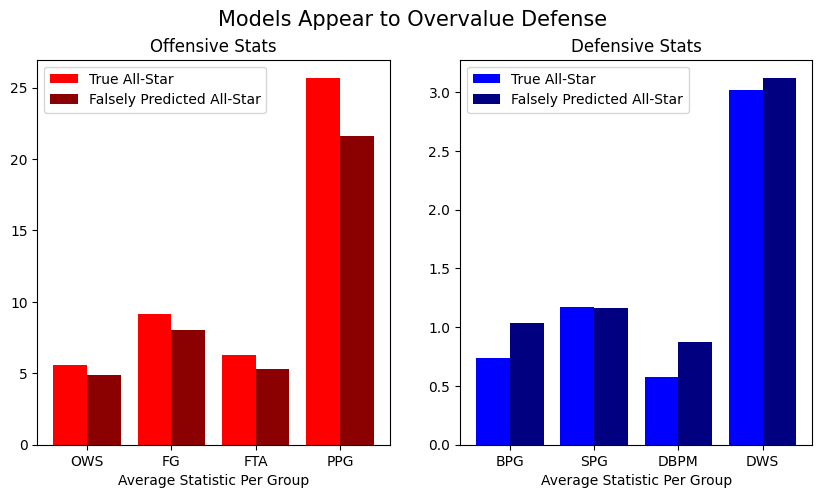

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5)) 
false_pred = s_24[(s_24['AS']==0) & ((s_24['LR']==1) | (s_24['NN']==1) | (s_24['RF']==1))] 
as_24 = s_24[s_24['AS']==1]

def_stats = ['BPG', 'SPG', 'DBPM', 'DWS'] 
off_stats = ['OWS', 'FG', 'FTA', 'PPG'] 
x=np.arange(len(off_stats)) 
y_off_as = [np.mean(as_24[stat]) for stat in off_stats]  
y_off = [np.mean(false_pred[stat]) for stat in off_stats] 
y_def_as = [np.mean(as_24[stat]) for stat in def_stats]  
y_def = [np.mean(false_pred[stat]) for stat in def_stats] 

plt.suptitle('Models Appear to Overvalue Defense', size=15) 

ax[0].set_title("Offensive Stats")
ax[0].bar(x-0.2, height=y_off_as, width=0.4, color='red') 
ax[0].bar(x+0.2, height=y_off, width=0.4, color='darkred')
ax[0].set_xticks(x) 
ax[0].set_xticklabels(off_stats)
ax[0].set_xlabel("Average Statistic Per Group")
ax[0].legend(['True All-Star', 'Falsely Predicted All-Star']) 

ax[1].set_title("Defensive Stats")
ax[1].bar(x-0.2, height=y_def_as, width=0.4, color='blue') 
ax[1].bar(x+0.2, height=y_def, width=0.4, color='navy')
ax[1].set_xticks(x) 
ax[1].set_xticklabels(def_stats)
ax[1].set_xlabel("Average Statistic Per Group")
ax[1].legend(['True All-Star', 'Falsely Predicted All-Star'])

plt.show() 

We can further evaluate the models by comparing differences in specific statistics between true all-stars and falsely predicted all-stars. On average, true all-stars have higher offensive impact and opportunity. It is important to note that true all-stars generally include all of the established superstars, so numbers will be skewed by the top few players. This does not however, explain why defensive metrics seem to be in favour of falsely predicted all-stars. There are a few ways to interpret the higher defensive metrics for false all-stars: 

1. The models overvalue defensive impact 
2. The models undervalue offensive impact 
3. Defensive players used to be more favoured in all-star selection 
3. These are anomlies 

Examining individual cases gives some explanation to the results. Looking at the table of falsely predicted all-stars, a few players stand for their defensive impact. Chet Holmgren and Victor Wembanyama stand out with their incredible defensive statistics, particularily with blocked shots and defensive box plus minus. Their status as rookies could be a key reason for their absence from official all-star rosters. Other notable high level defensive players include Kristaps Porzingis, Jimmy Butler, and Jarett Allen. Potential explanations for not being selected to all-star teams could be that they were overshadowed by teammates or that their box score statistics were not as prominent as others. 

Despite these rationalizations, there may be external factors that led to their exclusion from all-star teams. The models are all trained on historical data spanning decades. Given that many of them incorrectly predicted strong defensive players as all-stars, it seems that defensive players are less likely to be all-stars than in the past. Several factors may contribute to this, including the marketability of scorers and influence of the fan vote. 


### All-Star Stats

Based on the feature importance determined by the models, VORP (Value Over Replacement Player) and WS (Win Shares) appear to be some of the most important features. The graph below plots VORP against WS for each player in the top 30 highest VORP players. The aim is to discover what relationship exists between the two statistics, and how it impacts all-star selection. 

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


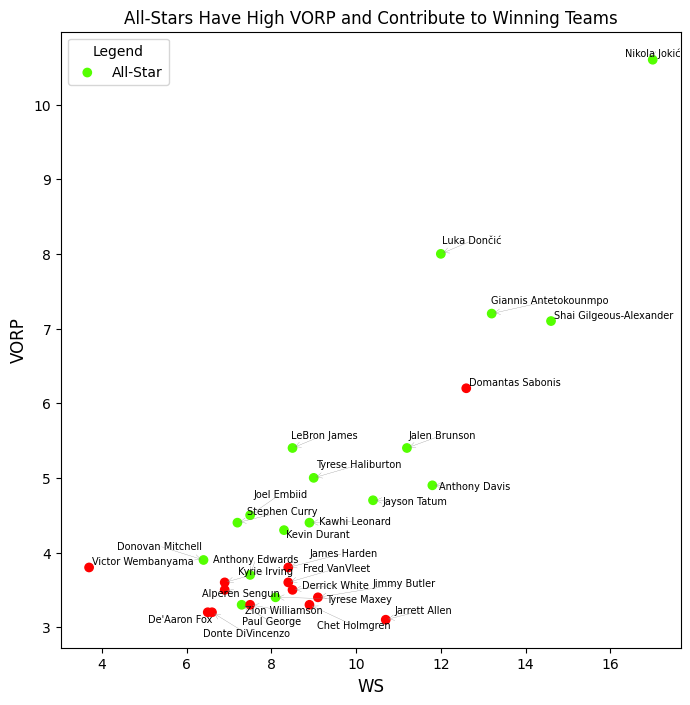

In [27]:
top_stat = s_24.sort_values(by='VORP', ascending=False).head(30) .set_index('Player') 
    
fig, ax = plt.subplots(figsize=(8, 8))
scatter = plt.scatter(top_stat['WS'], top_stat['VORP'], c=top_stat['AS'], cmap='prism') 

texts = [] 
for i, player in enumerate(top_stat.index):
    texts.append(ax.annotate(player, (top_stat['WS'][i], top_stat['VORP'][i]), size=7))

adjust_text(texts, force_points=0.1, arrowprops=dict(arrowstyle='->', color='gray', lw=0.2))

plt.xlabel(top_stat['WS'].name, size=12)
plt.ylabel("VORP", size=12)
plt.title("All-Stars Have High VORP and Contribute to Winning Teams", size=12) 
plt.legend(['All-Star'], title="Legend")
plt.show()

In the plot, green dots represent all-stars, while red dots represent non all-stars. There is a clear positive relationship between Win Shares and VORP; when they increase, players are more likely to be all-stars. A key factor in Victor Wembanyama missing the cut also becomes apparent; his win share statistic is very low compared to other players with high VORP. This supports the hypothesis that contributing to a winning team is important for the selection. Notable players with relatively low VORP and WS that were all-stars include Donovan Mitchell, Anthony Edwards, Paul George, and Tyrese Maxey. Their selection may be more closely related to their standout box score statistics. The last clear anomoly is Domantis Sabonis, who excels in both statistics, yet misses the all-star cutoff. This may be because of his weaknesses defensively, which goes against the hypothesis that offense is more valued than defense. 

### Model Comparison 

Further analysis can provide confidence levels on all-star predictions. The plot below illustrates how many models correctly predicted each all-star. When more models correctly predict and all-star, it should increase the confidence that the player deserved to be one. 

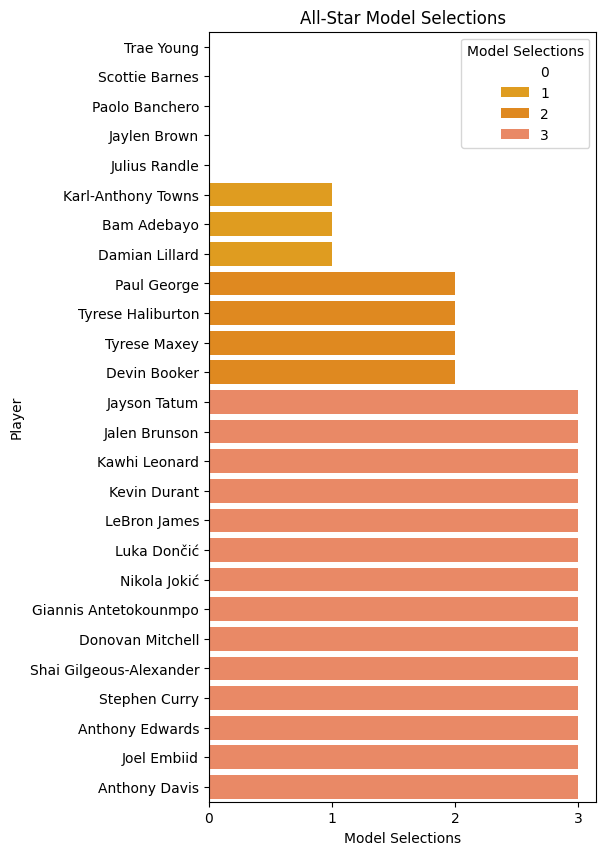

In [28]:
as_24 = s_24[s_24['AS']==1]

def m_count(row): 
    count = 0 
    if row['NN']==1: 
        count+=1 
    if row['RF']==1:
        count+=1 
    if row['LR']==1:
        count+=1 
    return count 
        
as_24['MC'] = as_24.apply(lambda x: m_count(x), axis=1)
as_24 = as_24.sort_values('MC')

fig, ax = plt.subplots(figsize=(5, 10))
bar = sns.barplot(as_24, y='Player', x='MC', hue='MC', orient='h', palette=['white', 'orange', 'darkorange', 'coral']) 
plt.xticks(np.arange(0, 4))
plt.xlabel('Model Selections')
plt.title("All-Star Model Selections")
plt.legend(title = 'Model Selections')

plt.show() 

Models were generally in agreement with all-star predictions for prime superstars. The differences come from players with less prominant statistical impact or who are more specialized with unique skill sets. Players like Bam Adebayo and Damian Lillard were absent from all-star predictions in at least one model. They stand in stark constrast to each other, with Bam being a versatile defender and inside the arc threat offensively. In contrast, Dame is a deep-range shot creator and pick and roll ball handler. Their absence from certain model predictions indicates how statistical strengths and weaknesses can create polarizing results. For the players that were not predicted by any of the models, the likely explanation is that their presence as all-stars is not reflected by statistics, but rather by other factors. Possible explanations are as follows: 

1. The success of the Timberwolves and KAT's unique skills at his size make him perceived as all-star worthy 
2. Scottie Barnes being the sole all-star Raptor united voters, while his overall verstatility and youth led him to be selected as an all-star 
3. Team success, athleticism, skills, and smarts led to Jaylen Brown's all-star selection 
4. Trae Young's incredible offensive ability overshadowed his defensive weakness and he was selected as an all-star 

A common theme among all-stars is that they bring multiple high-level skills to the court that are difficult to replace. Unlike role players that bring only one aspect to the court (ex. shooting, on-ball defense, etc.), all-stars have multiple skills and perform them at a high-level. 

### All-Stars Versus the Rest of the League 
The following plots take a step back to look at the big picture. They each include two curves; one with no all-stars, and one with only all-stars. This includes every player in every season since the 1979-80 season. The curves provide clarity as to how the average all-star differs from the average player, as well as insights into the extremes of both groups. These groups (all-star vs. non all-star) are illustrated in the form of distributions, where the total area under each curve represents every player in each group, and the height represents the proportion of each group with the given stat. 

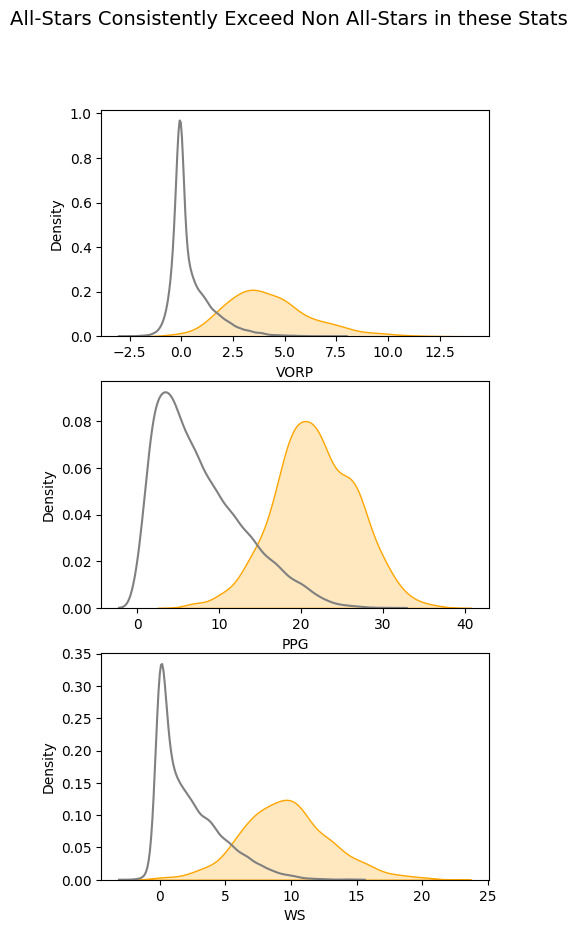

In [29]:
is_allstar = master[master['AS']==True] 
non_allstar = master[master['AS']==False] 

fig, ax = plt.subplots(figsize=(5, 10), nrows=3)
sns.kdeplot(is_allstar['VORP'], ax=ax[0], fill=True, color='orange')
sns.kdeplot(non_allstar['VORP'], ax=ax[0], color='grey')

sns.kdeplot(is_allstar['PPG'], ax=ax[1], fill=True, color='orange')
sns.kdeplot(non_allstar['PPG'], ax=ax[1], color='grey')

sns.kdeplot(is_allstar['WS'], ax=ax[2], fill=True, color='orange')
sns.kdeplot(non_allstar['WS'], ax=ax[2], color='grey')

plt.suptitle("All-Stars Consistently Exceed Non All-Stars in these Stats", size=14) 

plt.show() 

In the distributions, it is clear that the all-star distributions (orange curves) generally exceed the non all-star curves for each given stat. This is not always the case, since there is a portion under each non all-star curve that exceeds a portion under the all-star curve. This shows that it is generally the case that all-stars exceed non all-stars in key stats, but the distinction is not absolute. Decisions to select all-stars are often based on many stats, and focusing too heavily on only a few of them could lead to innaccurate results. 

## Conclusions 

There are several conclusions about the all-star selection process from this analysis. Some of the important conclusions about NBA all-stars that we discovered in this analysis are as follows: 

1. All-stars usually have high VORP, are high volume scorers, and contribute on winning teams 
2. Offensive output, particularily scoring, is usually favoured over defensive metrics in recent seasons 
3. All-stars bring multiple or unique high-level skills to the court that are difficult to replace 


